In this notebook the optimal model configurations for each set of inner folds used during the error estimation procedure are tested against the outer folds. The expected model error is the average of the error estimated within each outer fold.

Import the calibration results from the inner folds.

In [68]:
import pandas as pd

inner_folds = pd.read_csv("./data/calibration/inner_folds_results/population171000.csv")

Declare objects needed for the training pipeline: names of hyper-parameters and names of predictors.

In [18]:
import re
from pathlib import Path

hyper_parameter_names = {
    "n_estimators" : "n_estimators",
    "learning_rate" : "e",
    "max_depth" : "md", 
    "min_child_weight" : "mcw",
    "subsample" : "subsample",
    "min_split_loss" : "g",
    "max_delta_step" : "mds"
}
# This operation is only used to generate a list of predictor names.
bioclimatic_data_directory = "./data/bioclimatic_data/"
bioclimatic_data_files = {
    re.findall("CHELSA_(.*)_1981",fname.stem)[0] : (str(fname),"float") for fname in Path(bioclimatic_data_directory).glob('CHELSA*.tif')
}
predictor_names = list(bioclimatic_data_files.keys())



Iterate over each outer fold, train the model on the inner folds and calculate Mean Absolute Error on the outer fold data. Repeat the procedure N times for a more robust estimate. In each fold we take the median MAE of all the replicas. Then we estimate the overall median and average MAE across all outer cross-validation folds. 

In [58]:
from sklearn.metrics import mean_absolute_error
from training import training_pipeline
import numpy as np

data = pd.read_csv("./data/training/agbd_climate_training_dataset_spatialkfolds_1000km.csv")

error_df= pd.DataFrame()
for fold in inner_folds["id"].unique():
   
    agbd_train = data[data["fold_1000km"]!=int(fold)]
    agbd_test = data[data["fold_1000km"]==int(fold)]

    parameters = inner_folds[inner_folds['id'] == fold].reset_index()

    parameters["n_estimators"] = 3000

    agbd_estimator = training_pipeline(parameters,hyper_parameter_names,predictor_names, logarithmize_agbd=True)
    
    y_test = agbd_test["agbd"]
     
    repeats = 10

    try: 
        for i in range(repeats):
            model = agbd_estimator.fit(agbd_train, agbd_train["agbd"])
            y_predict = model.predict(agbd_test)

            y_predict = np.where(y_predict<0,0.0,y_predict)

            mae = mean_absolute_error(y_test,y_predict)

            row = pd.DataFrame(data={"fold":[int(fold)],"mae":[mae]} )

            error_df = pd.concat([error_df,row],axis='rows')
    except:
        continue 

average_mae = error_df.groupby("fold").agg("median").mean()
median_mae = error_df.groupby("fold").agg("median").median()

print("Average MAE across outer cross-validation folds:", average_mae)
print("Median MAE across outer cross-validation folds:", median_mae)

/home/dibepa/git/agbd.clim/training.py:95: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n_estimators=int(parameters[hp_names["n_estimators"]]),
/home/dibepa/git/agbd.clim/training.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  learning_rate=float(parameters[hp_names["learning_rate"]]),
/home/dibepa/git/agbd.clim/training.py:97: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  max_depth = int(parameters[hp_names["max_depth"]]),
/home/dibepa/git/agbd.clim/training.py:98: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  min_child_weight=float(parameters[hp_names["min_child_weight"]]),
/home/dibepa/git/agbd.

Plot the cumulative distribution of MAEs, together with the median and mean lines. The mean line is close to the 70th percentile of the distribution.

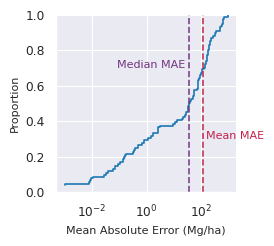

In [67]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})
sns.set_style("darkgrid")

g = sns.displot(data = error_df, x="mae", kind="ecdf",log_scale=True,height=2.5)
g.set(xlabel="Mean Absolute Error (Mg/ha)")
ax = g.axes
ax[0][0].axvline(x = median_mae["mae"],color="#733380",alpha=0.9,linestyle='--')
ax[0][0].axvline(x = average_mae["mae"],color="#C32148",alpha=0.9,linestyle='--')
ax[0][0].text(0.08, 0.7, "Median MAE", fontsize=8,color="#733380")
ax[0][0].text(150, 0.3, "Mean MAE", fontsize=8,color="#C32148")
plt.savefig("{}cumulative_MAE.png".format("./figures/"),dpi=300)
plt.savefig("{}cumulative_MAE.svg".format("./figures/"))
plt.show()